In [19]:
# Original file name: tis.ipynb from Rare Event Summer School in Dropbox
# New file name: (RE)TIS-Code.ipynb
# Modified by PH Minh
# Last Updated Date: 03-17-2023 

## RETIS Tutorial


## Learning Objectives

1. Understand what a replica exchange (RE) move is in transition interface sampling (TIS).  

    - How is RETIS different from TIS?  
    </br>

2. Explore the importance of interface placement and interface type on a given potential energy surface (PES).
    * To do this exploration, you can modify the following variables in the code:

        - **pes_type**: this will change the PES that you use for your simulation 

        - **op_type**: this will change the form of your op. The options provided are op_type = x, y, or x+y

        - **interfaces values** in the interface list: this will change where you place your interface

        - **basinA; basinB**: this will change where you define your basin(s) on the PES

        - **init_coords**: this will change where you start on your PES in your simulation

        - **beta**: this will change the temperature since beta = 1/(k_B*T), which consequently also changes the PES barrier height due to the change in temperature (T)

    * Questions to think about while exploring: 

        - How does changing variables related to the PES/my system (like pes_type, beta, basinA, basinB) impact my sampling?
        
        - How does changing variables related to RETIS methodology (like op_type, interfaces values, init_coords) impact my sampling?

3. Understand the procedure in RETIS sampling and the reason behind these steps that we follow for performing a RETIS "simulation".

    - Why do we need to run an intial simulation at a higher temperature?

</br>
        
4. Gain knowledge of sampling checks for RETIS work and understand what information each sampling check provide about our system.

    - What does "running average crossing probability of each interface" tell you about your sampling? 

    - What does "autocorrelation functions/graphs" tell you about your sampling? 

    - What does "the crossing probability histogram" tell you about your sampling? 
    
    - How will you decide how many more moves to run your RETIS?

## Plot potential energy surface contours

PES-1: $$ Equation $$
PES-2: $$ Equation $$
PES-3: $$ Equation $$
PES-4: $$ Equation $$


## 1
<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-1.png"> 

## 2
<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-2.png"> 

## 3
<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-3.png">

## 4
<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-4.png">

## Choose your PES

In [ ]:
import numpy as np
import sys
import math
import copy
from math import exp
import langevin_dynamics as ld
import random
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm

# Select your PES type: ***** EDIT HERE *****
pes_type = 1

if pes_type == 4:
    # Plot potential energy surface contours
    N = 100
    x_vec = np.linspace(-2, 0.5, N)
    y_vec = np.linspace(0, 2, N)
    X, Y = np.meshgrid(x_vec, y_vec)
    energy = np.zeros((N, N))
    
    # Plot contours
    for i in range(len(x_vec)):
        for j in range(len(y_vec)):
            energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)
    plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
    cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
    cbar.set_ticks([])
    cbar.set_label(label = 'Energy', size=12)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show

else:
    # Plot potential energy surface contours
    N = 100
    x_vec = np.linspace(-3.5, 3.5, N)
    y_vec = np.linspace(-3.5, 3.5, N)
    X, Y = np.meshgrid(x_vec, y_vec)
    energy = np.zeros((N, N))

    # Plot contours
    for i in range(len(x_vec)):
        for j in range(len(y_vec)):
            energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)
    plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')
    cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
    cbar.set_ticks([])
    cbar.set_label(label = 'Energy', size=12)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show

## Simulation Settings

<function matplotlib.pyplot.show(close=None, block=None)>

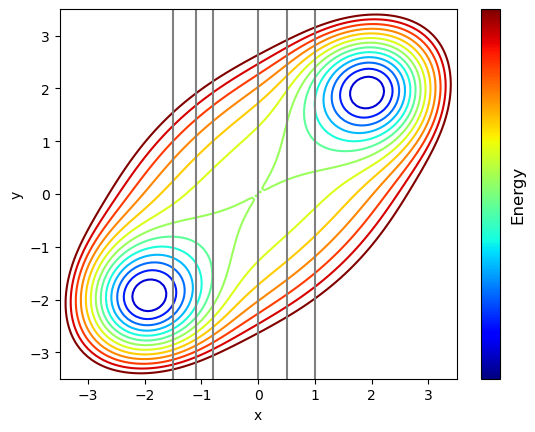

In [21]:
# RETIS settings
n_moves = 1500              # number of moves to perform for each path ensemble - path ensemble corresponding to each diff interface
op_type = 1                 # order parameter;  1:x  2:y  3:x+y

interfaces = [-1.5, -1.1, -0.8, 0.0, 0.5, 1.0, 2.0]

basinA = -2.09              # boundary of basin A; must be less than the first interface
basinB = interfaces[-1]     # basin B defined as last interface
init_coords = [-1, -1]      # initial coordinates
init_p = [0, 0]             # initial momenta
basineqlen = 5000           # basin equilibration length (steps)
basinlen = 50000            # basin simulation length
sigma = 0.5                 # standard deviation of momenta perturbation

# Langevin Dynamics Settings
beta = 2.5                  # 1/kT
gamma = 5.0                 # friction
dt = 0.01                   # time step size



# Plot PES contours with interfaces
# Plot contours
for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)

if pes_type == 4:
    plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
else:   
    plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')

# Plot interfaces
for i in range(len(interfaces)-1):
    plt.plot(np.linspace(interfaces[i],interfaces[i],10),np.linspace(min(y_vec),max(y_vec),10), color='grey')

cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
cbar.set_ticks([])
cbar.set_label(label = 'Energy', size=12)
plt.xlabel('x')
plt.ylabel('y')
plt.show


## Equilibration Run

In [22]:
# Declare array to store basin trajectory
basintraj = np.zeros((basinlen + 1, 6),dtype=float)                             # matrix: each row is the next configuration and each column is x, y, px, py, fx, fy

# Calculate initial forces
fx,fy = ld.force(init_coords[0],init_coords[1],init_p[0],init_p[1],dt,beta,gamma,pes_type)

# Combine positions, momenta, and forces to make an initial phase point
init_phasepoint = init_coords + init_p + [fx,fy]
basintrajeq = ld.vv_step(init_phasepoint,dt,beta,gamma,pes_type)                # use velocity verlet to generate the next configuration of x, y, px, py, fx, fy

# Equilibrate in basin
for i in range(1,basineqlen + 1):
    new_basintrajeq = ld.vv_step(basintrajeq,dt,beta,gamma,pes_type)            # array of x, y, px, py, fx, fy
    basintrajeq = new_basintrajeq
    op = ld.calc_op(op_type,basintrajeq[0],basintrajeq[1])                      #ld.calc_op(op_type, x, y of the trajectory)
    # check if trajectory reaches basin B
    if op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")


In [23]:
# Visualizing equilibration 

# for i in range(len(x_vec)):
#     for j in range(len(y_vec)):
#         energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)

# if pes_type == 4:
#     plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
# else:   
#     plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')

# plt.scatter(basintraj[:,0],basintraj[:,1]) 

# cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
# cbar.set_ticks([])
# cbar.set_label(label = 'Energy', size=12)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show


## Run a basin simulation

- Why do we need to run basin simulation?

**[Answer: Edit Text]**

<function matplotlib.pyplot.show(close=None, block=None)>

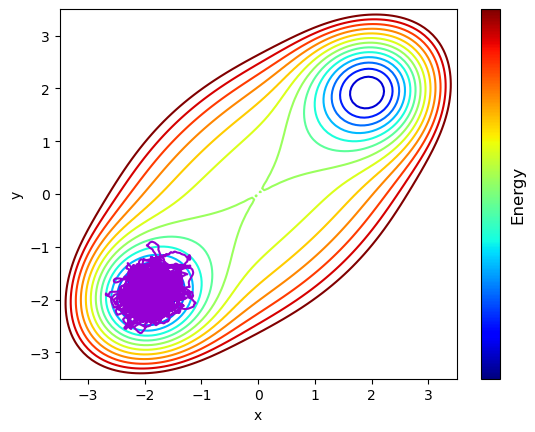

In [24]:
basintraj[0] = basintrajeq                                                      # saving the last configuration from the equilibration run as the first config for prod run
fromBasin = False
n_cross_flux = 0

# Run one basin A simulation and check for first crossings
for j in range(1,basinlen + 1):
    basintraj[j] = ld.vv_step(basintraj[j-1],dt,beta,gamma,pes_type)            # each iteration is a configuration so that basintraj at the end makes a matrix
    op = ld.calc_op(op_type,basintraj[j][0],basintraj[j][1]) 
    
    if op < basinA:
        fromBasin = True
    
    if fromBasin == True and op >= interfaces[0]: 
        n_cross_flux += 1
        fromBasin = False
    
    # Check if trajectory reaches basin B
    if op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")

if n_cross_flux == 0:
    sys.exit("No first crossings obtained from basin A to interface 0. Exiting...")


# Visualizing basin simulation 

for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)

if pes_type == 4:
    plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
else:   
    plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')

plt.plot(basintraj[:,0],basintraj[:,1],color='darkviolet') 

cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
cbar.set_ticks([])
cbar.set_label(label = 'Energy', size=12)
plt.xlabel('x')
plt.ylabel('y')
plt.show


## Generate the initial paths by simulating at a higher temperature

- Why do we need to generate an initial path at a higher temperature? **Bonus**: How do we control the temperature? 

**[Answer: Edit Text]**

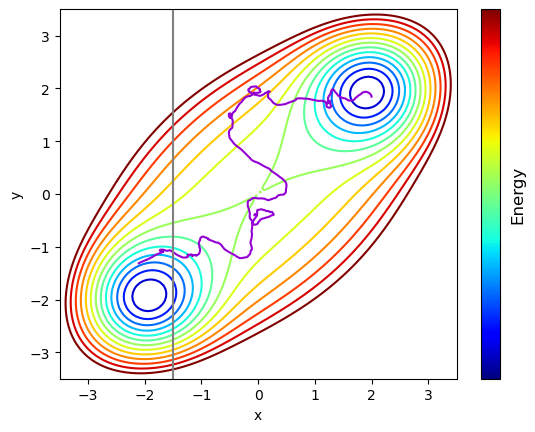

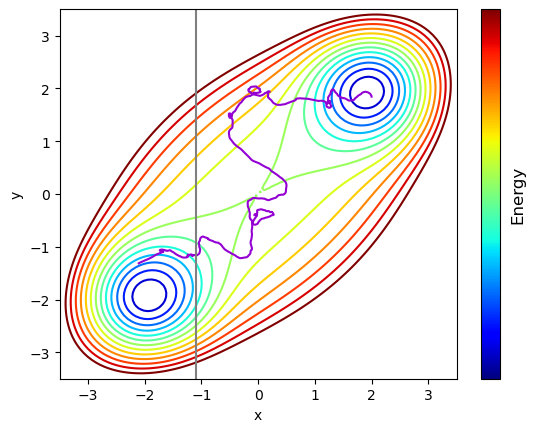

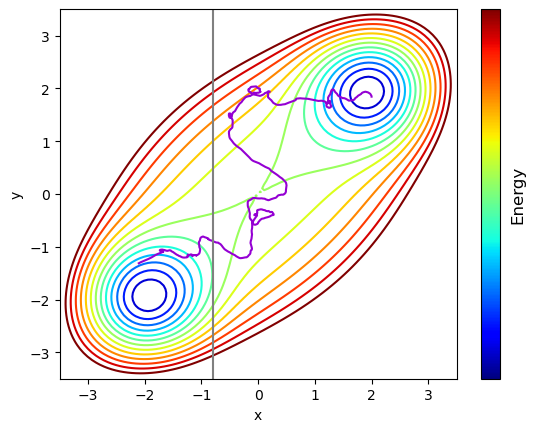

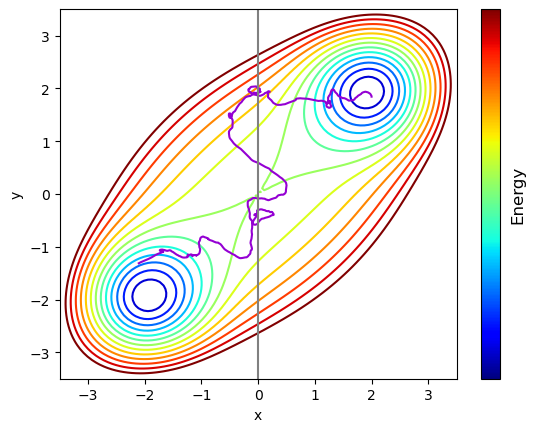

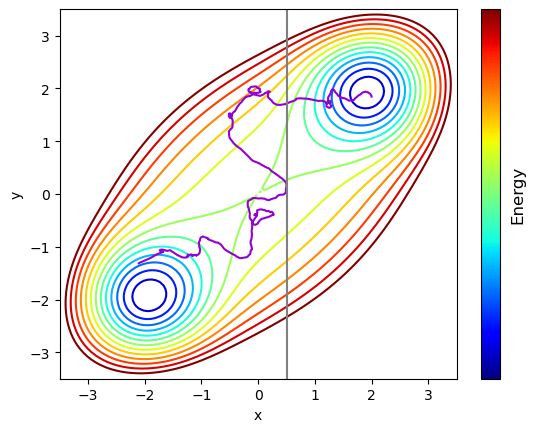

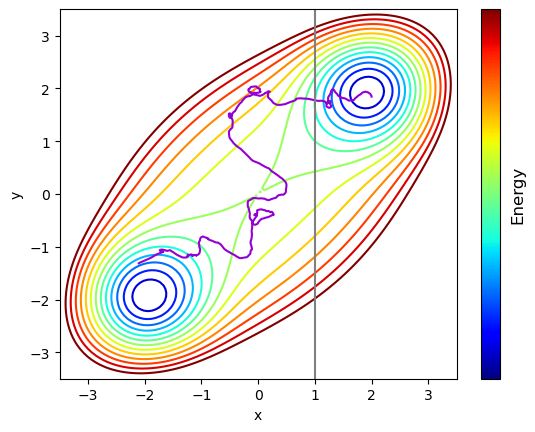

In [25]:
# Run at higher temperature to generate an initial path
initpath = []
beta_initpath = 1.5                                                     # this controls the temperature because beta = 1/kb*T
fromBasin = False

# Use init_phasepoint to start trajectory
trajstep = ld.vv_step(init_phasepoint,dt,beta_initpath,gamma,pes_type)  # array of x, y, px, py, fx, fy to get the first config to generate a path
op = ld.calc_op(op_type,trajstep[0],trajstep[1])                        # calculate the op to see where this config is at, in A or pass A and cross some lambda, or in B?

while op < basinB:                                                      # as long as it is not in B
    nextstep = ld.vv_step(trajstep,dt,beta_initpath,gamma,pes_type)              # generate next config
    trajstep = nextstep                                                 # save this config to trajstep, so we could shoot from it again 
    op = ld.calc_op(op_type,trajstep[0],trajstep[1])

    if op < basinA:                                                     # if this then this traj is from basin A 
        fromBasin = True
        initpath = []                                                   # reset path if it returns to A - do this until it's about to leave the basin
        trajstep = np.append(trajstep,[op],axis=0)                      # array of x, y, px, py, fx, fy and op value
        initpath.append(trajstep) 
        continue

    if op >= basinA and fromBasin == True:                              # now that you have left basin A, we'll save the different configs to the list initpath
        trajstep = np.append(trajstep,[op],axis=0)
        initpath.append(trajstep)
        continue

initpath = np.asarray(initpath)                                         # this gives all configurations of this 1 initial path
allpaths = [[] for i in range(len(interfaces)-1)]                       # list of empty lists of size len(interfaces)-1, each empty list is a placeholder for paths in 1 interface 

for i in range(len(interfaces)-1):                                      # loop over amt of interface starting from 0 
    allpaths[i].append(initpath)    


# Visualize initial paths for each interface

for i in range(len(interfaces) - 1):
    plt.figure()

    if pes_type == 4:
        plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
    else:   
        plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')
        
    for j in range(0,len(allpaths[i])):
        plt.plot(allpaths[i][j][:,0],allpaths[i][j][:,1],color='darkviolet')               # allpaths[i] tells you the interface ensemble you're in, 
                                                                                           # [j] tells you a specific path in that ensemble, [:,0/1] takes 
                                                                                           # all the x/y values of the paths in i
    
    plt.plot(np.linspace(interfaces[i],interfaces[i],10),np.linspace(min(y_vec),max(y_vec),10), color='grey')
    
    cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
    cbar.set_ticks([])
    cbar.set_label(label = 'Energy', size=12)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show 

## Perform RETIS

In [26]:
# Define function to find index of a certain OP value along a path 
def find_config_minus(path,interfaces):
    frame = np.where(path[:,6] > interfaces)[0][0] - 1
    return frame

def find_config_plus(path,interfaces):
    frame = np.where(path[:,6] < interfaces)[0][-1] + 1
    return frame

In [27]:
for move in range(1, n_moves):

    # Swap or Shoot? 
    ss = np.random.ranf()
    
    # Perform swap move
    if ss < 0.5: 

        # Decides on which ensemble pair switching we're doing
        ens_switch = np.random.ranf() 
        
        if ens_switch < 0.5: 
            print('Move = {} ; Performing Swap Move: 1-2, 3-4, 5-6...etc'.format(move))
            
            # Accounting for the 1st interface, but first we need to check that it satisfies the ensemble criteria
            if np.where(allpaths[0][-1][:,6]>interfaces[0])[0].shape[0] == 0: 
                reject_move = True
                # print('Appending Rejected!')
            else:
                allpaths[0].append(allpaths[0][-1])                             # append the previous 0th ensemble path to its own ensemble again because 
                                                                                # there is no pair for this interface to swap with
            
            # For even number of interfaces:
            if (len(interfaces)-1)%2 == 0:                      
                
                # Accounting for the last interface 
                if np.where(allpaths[-1][-1][:,6]>interfaces[-2])[0].shape[0] == 0: 
                    reject_move = True
                    # print('Appending Rejected!')
                else:
                    allpaths[-1].append(allpaths[-1][-1])                       # append the previous path of the last ensemble to its own ensemble again because 
                                                                                # there is no pair for this interface to swap with
                
                # Accounting for the rest of the interfaces
                for i in np.arange(1,len(interfaces)-3,2):
                    # print('i = ', i)
                    path_1 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                    path_2 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                    
                    # Check if path 1 crosses path 2's interface
                    n_cross_config = np.where(path_1[:,6]>interfaces[i+1])[0].shape[0]

                    if n_cross_config != 0:                                     # if the swap is successful, do the swap
                        # print('Successful Swap!')
                        allpaths[i].append(path_2)
                        allpaths[i+1].append(path_1)
                        
                    else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                        # print('Unsuccessful Swap!')
                        allpaths[i].append(path_1)
                        allpaths[i+1].append(path_2)
                    
            # For odd number of interfaces:
            else:                              
                for i in np.arange(1,len(interfaces)-1,2):
                    # print('i = ', i)
                    path_1 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                    path_2 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                    
                    # check if path 1 crosses path 2's interface
                    n_cross_config = np.where(path_1[:,6]>interfaces[i+1])[0].shape[0]

                    if n_cross_config != 0:                                     # if the swap is successful, do the swap
                        # print('Successful Swap!')
                        allpaths[i].append(path_2)
                        allpaths[i+1].append(path_1)
                    
                    else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                        # print('Unsuccessful Swap!')
                        allpaths[i].append(path_1)
                        allpaths[i+1].append(path_2)
       
        else:
            print('Move = {} ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc'.format(move))
            
            # For even number of interfaces: 
            if (len(interfaces)-1)%2 == 0:
                for i in range(0,len(interfaces)-1,2):
                    # print('i = ' ,i)
                    path_0 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                    path_1 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                    
                    # Check if path 1 crosses path 2 interface
                    n_cross_config = np.where(path_0[:,6]>interfaces[i+1])[0].shape[0]

                    if n_cross_config != 0:                                     # if the swap is successful, do the swap
                        # print('Successful Swap!')
                        allpaths[i].append(path_1)
                        allpaths[i+1].append(path_0)
                    
                    else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                        # print('Unsuccessful Swap!')
                        allpaths[i].append(path_0)
                        allpaths[i+1].append(path_1)
                    
            # For odd number of interfaces:
            else: 
                
                # Accounting for the last interface:
                if np.where(allpaths[-1][-1][:,6]>interfaces[-2])[0].shape[0] == 0: 
                    reject_move = True
                    # print('Appending Rejected!')
                else: 
                    allpaths[-1].append(allpaths[-1][-1])                       # append the previous path of the last ensemble to its own ensemble again 
                                                                                # because there is no pair for this interface to swap with
                
                # Accounting for the rest of the interfaces:
                for i in range(0,len(interfaces)-2,2):
                    # print('i = ' ,i)
                    path_0 = allpaths[i][move-1]                                # looks at the most current path of the TPE of interface i
                    path_1 = allpaths[i+1][move-1]                              # looks at the most current path of the TPE of interface i+1
                    
                    # Check if path 1 crosses path 2 interface
                    n_cross_config = np.where(path_0[:,6]>interfaces[i+1])[0].shape[0]

                    if n_cross_config != 0:                                     # if the swap is successful, do the swap
                        # print('Successful Swap!')
                        allpaths[i].append(path_1)
                        allpaths[i+1].append(path_0)

                    else:                                                       # if the swap is unsuccessful, just append the same path to their own ensemble
                        # print('Unsuccessful Swap!')
                        allpaths[i].append(path_0)
                        allpaths[i+1].append(path_1)
                    
    # Perform shooting move
    else: 
        print('Move = {} ; Performing Shoot Move'.format(move))

        for i in np.arange(len(interfaces)-1):                                  # i signifies the interface that I'm looking at
            # print('i = ', i)
            path = allpaths[i][move-1]                                          # looks at the most current path of the TPE of interface i
            reject_move = False
            lmax = round((len(path) + 1)/np.random.uniform())                   # l max = maximum path length for flexible shooting 
            
            # Pick random shooting point 
            if i == 0:
                minus_frame = find_config_minus(path, basinA)                   # find the index corresponding to interface i-1    
                plus_frame = find_config_plus(path, interfaces[i+1])            # find the index corresponding to interface i+1 
                index = np.random.randint(minus_frame,plus_frame)

            # Pick random shooting point between i-1 and i+1
            else:               
                minus_frame = find_config_minus(path, interfaces[i-1])          # find the index corresponding to interface i-1    
                plus_frame = find_config_plus(path, interfaces[i+1])            # find the index corresponding to interface i+1  
                index = np.random.randint(minus_frame,plus_frame)

            # Perturb the momenta
            shoot_point = copy.deepcopy(path[index])                            # gives me 1 phase space point/config along the path
            shoot_point[2] += np.random.normal(0,sigma)                         # px
            shoot_point[3] += np.random.normal(0,sigma)                         # py
            trial_path = np.asarray([shoot_point])                              # new trial path after perturbing the momenta

            if exp(-beta*(ld.kinetic_energy(shoot_point) - ld.kinetic_energy(path[index]))) < np.random.uniform():
                # the if is testing to see if we want to use this new trial path (after momenta is perturbed) 
                # before even shooting it
                reject_move = True
                # print('Shooting Move Rejected! Momenta Perturbation Failed!') 

            # Integrate backwards path if we have not rejected the move...
            if reject_move == False:
                path_length = 1
                trial_path[:,2] *=-1                                            # change px to the negative direction by * -1
                trial_path[:,3] *=-1                                            # change py to the negative direction by * -1
                trajstep = copy.deepcopy(trial_path[-1])                        # take the last config of trial path
                op = ld.calc_op(op_type,trajstep[0],trajstep[1])                # calc op value for config

                while op >= basinA:
                    trajstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)   # ld.vv_step(x,y,px,py,fx,fy,dt,beta,gamma)
                    op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                    trajstep = np.append(trajstep,[op],axis=0)
                    trial_path = np.append(trial_path,[trajstep],axis=0)
                    path_length +=1

                    # Reject if the maximum path length is exceeded
                    if path_length > lmax:
                        reject_move = True
                        # print('Shooting Move Rejected! Pathlength limit!')
                        break

                    # Reject if the backward path segment goes to B
                    if op >= basinB:
                        reject_move = True
                        # print('Shooting Move Rejected! Backward segment reaches B!')
                        break

            # Forward shooting             
            if reject_move == False: 
                trial_path = np.flip(trial_path,axis=0)                          # flip it from the back to front of this trial path (because it was shooting backwards), 
                                                                                 # so we flip so that the last config we extract from here will be where we'll use to shoot forward
                trial_path[:,2] *=-1
                trial_path[:,3] *=-1
                trajstep = copy.deepcopy(trial_path[-1])
                op = ld.calc_op(op_type,trajstep[0],trajstep[1])
     
                while op > basinA and op < basinB:                               # this is so that it restricts forward shooting to either end in A or B

                    nextstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)
                    trajstep = nextstep
                    op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                    trajstep = np.append(trajstep,[op],axis=0)
                    trial_path = np.append(trial_path,[trajstep],axis=0)
                    path_length +=1
                    
                    if path_length > lmax:
                        reject_move = True
                        # print('Shooting Move Rejected! Pathlength Limit!')
                        break

            # Final chance to reject a path (because no crossing of interface i)
            if np.where(trial_path[:,6]>interfaces[i])[0].shape[0] == 0:        # np.where(condition)[0] tells you which array or which path satisfies this condition and 
                                                                                # the .shape[0] how many configs satisfy this, if 0, then we never cross the interface
                reject_move = True
                # print('Shooting Move Rejected! Did not cross its own interface!')
            
            # If we DON'T reject, then path becomes trial path
            if reject_move == False:
                # print('Shooting Move Accepted!')
                path = trial_path
            
            # Append current accepted path to its corresponding path ensemble
            allpaths[i].append(path)                                            # all paths contains all paths per each interface - i is to signify which interface 
                                                                                # ensemble we're looking at. So allpaths[0] will contain all paths that cross interface lambda 0

Move = 1 ; Performing Shoot Move
Move = 2 ; Performing Shoot Move
Move = 3 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 4 ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc
Move = 5 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 6 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 7 ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc
Move = 8 ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc
Move = 9 ; Performing Shoot Move
Move = 10 ; Performing Shoot Move
Move = 11 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 12 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 13 ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc
Move = 14 ; Performing Shoot Move
Move = 15 ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc
Move = 16 ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc
Move = 17 ; Performing Shoot Move
Move = 18 ; Performing Shoot Move
Move = 19 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 20 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 21 ; Performing Shoot Move
Move = 22 ; Performing 

## Sampling Quality Check 

**Running Avereage of the Crossing Probability of Each Interface Ensemble**:

- What does this sampling check calculates? What does it tell you about your sampling?


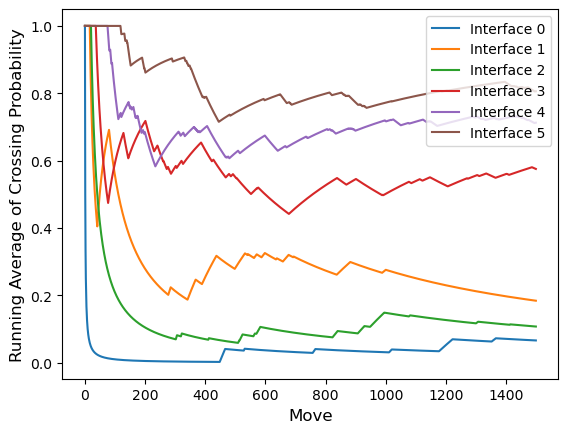

In [28]:
""" 1) Running Avereage of the Crossing Probability of Each Interface Ensemble """

ninterfaces = len(interfaces) - 1
allrunavg = [[] for i in range(ninterfaces)]

for i in range(ninterfaces):
    crosslist = []
    
    for move in range(0,n_moves,1):
        val = np.max(allpaths[i][move][:,6])                                # tells us how far the specific path belonging to that specific interface has travelled

        if val > interfaces[i+1]:
            crosslist.append(1)
        else:
            crosslist.append(0)
        
    crosses = np.asarray(crosslist)                                         # counts the crosses for that interface into the neighboring i+1 interface

    # Calculate the running average

    for j in range(len(crosses)):
        runavg = np.mean(crosses[:j+1])
        # print(runavg)
        allrunavg[i].append(runavg)

# Plot Running Average of Crossing Probability of Each Interface Ensemble

for i in range(ninterfaces):
    plt.plot(range(0,n_moves),allrunavg[i][:], label='Interface {}'.format(i))
    plt.xlabel('Move', fontsize=12)
    plt.ylabel('Running Average of Crossing Probability', fontsize=12)
plt.legend(loc='upper right')
plt.show()


**Autocorrelation Graphs**:

- What does this sampling check calculates? What does it tell you about your sampling?

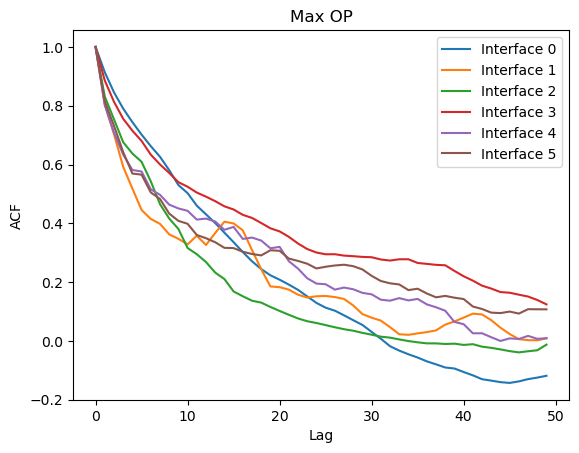

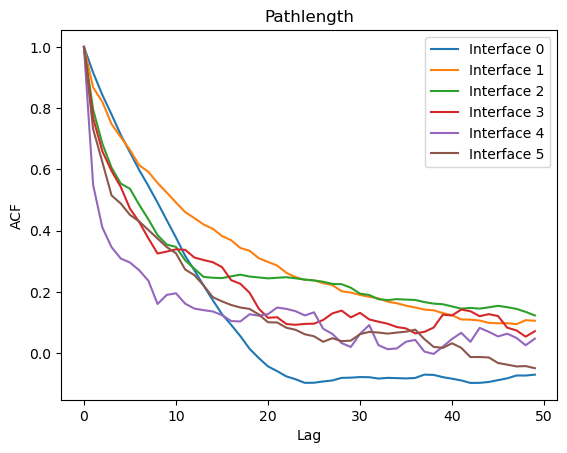

In [29]:
""" 2) Autocorrelation Graphs: a) Max OP, b) Pathlength, c) Indicator function, where it is 1 if path in i crosses i+1, 0 otherwise """
""" The equation used for ACF calculation is:   [INSERT]           """

maxlag = 50                                             # Define your max lag
acf_m = [[] for i in range(ninterfaces)]
acf_p = [[] for i in range(ninterfaces)]
acf_i = [[] for i in range(ninterfaces)]


for i in range(ninterfaces):
    maxOPvals = []                                      # List to store max OP values of each path of an interface ensemble
    pathlengthsvals = []                                # List to store pathlength values of each path of an interface ensemble
    indvals = []                                        # List to store indicator fn. values of each path of an interface ensemble

    start = 400                                         # You define what move the ACF starts at, this should correspond to where the running average crossing prob. converges
    
    # Gather information about each move for an interface ensemble
    for move in range(start,n_moves):                   
        maxOPvals.append(np.max(allpaths[i][move][:,6]))
        pathlengthsvals.append(len(allpaths[i][move]))
        
        ## EDIT THIS SO THAT YOU CAN USE INDICATOR FUNCTION SPECIFIED ABOVE AS A PROPERTY TO CALCULATE ACF ##

        # if XXXX:
        #     
        # else:
        #     
        
        ## END OF EDIT

    # Calculate ACF 
    
    # Get mean 
    maxop = np.asarray(maxOPvals)
    pl = np.asarray(pathlengthsvals)

    opavg = np.mean(maxop)
    plavg = np.mean(pl)

    # Get denominator
    denom_op = np.sum((maxop-opavg)**2)
    denom_pl = np.sum((pl-plavg)**2)

    # Get numerator 
    for lag in range(maxlag):
        sample = len(maxop) - lag                           # Number of samples that we're going to calculate ACF over
        
        acfmaxop = 0
        acfpl = 0
        acfind = 0

        for j in range(sample):
            numer_op = (maxop[j] - opavg)*(maxop[j+lag] - opavg)
            numer_pl = (pl[j] - plavg)*(pl[j+lag] - plavg)

            # Get ACF values
            acfmaxop += numer_op/denom_op
            acfpl += numer_pl/denom_pl

        acf_m[i].append(acfmaxop)
        acf_p[i].append(acfpl)

# Plot ACF Graphs 

for i in range(ninterfaces):
    plt.plot(range(0,lag+1),acf_m[i], label='Interface {}'.format(i))
    plt.xlabel('Lag')
    plt.ylabel('ACF')
plt.title('Max OP')
plt.legend()
plt.show()

for i in range(ninterfaces):
    plt.plot(range(0,lag+1),acf_p[i], label='Interface {}'.format(i))
    plt.xlabel('Lag')
    plt.ylabel('ACF')
plt.title('Pathlength')
plt.legend()
plt.show()


## Answer Key

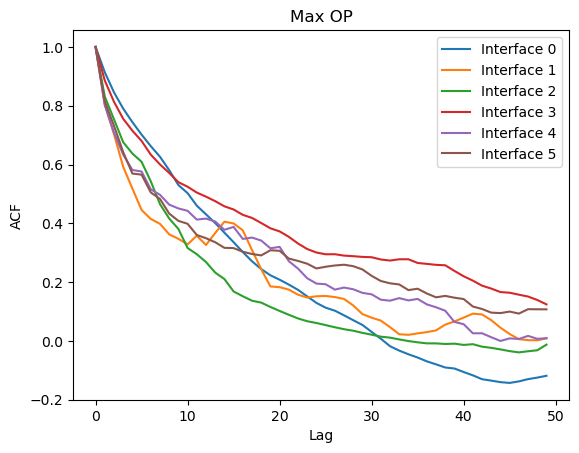

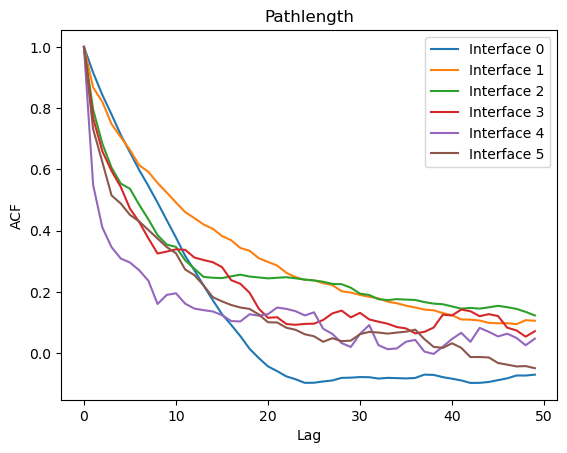

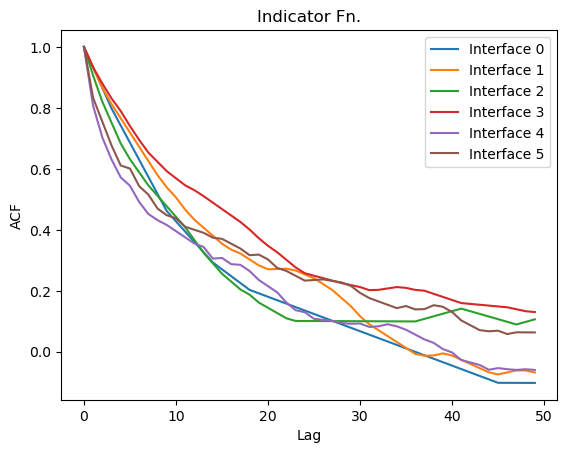

In [30]:
# """ Answer Key """

# maxlag = 50                                             # Define your max lag
# acf_m = [[] for i in range(ninterfaces)]
# acf_p = [[] for i in range(ninterfaces)]
# acf_i = [[] for i in range(ninterfaces)]


# for i in range(ninterfaces):
#     maxOPvals = []                                      # List to store max OP values of each path of an interface ensemble
#     pathlengthsvals = []                                # List to store pathlength values of each path of an interface ensemble
#     indvals = []                                        # List to store indicator fn. values of each path of an interface ensemble

#     start = 400                                         # You define what move the ACF starts at, this should correspond to where the running average crossing prob. converges
    
#     # Gather information about each move for an interface ensemble
#     for move in range(start,n_moves):                   
#         maxOPvals.append(np.max(allpaths[i][move][:,6]))
#         pathlengthsvals.append(len(allpaths[i][move]))
        
#         if np.max(allpaths[i][move][:,6]) > interfaces[i+1]:
#             indvals.append(1)
#         else:
#             indvals.append(0)

#     # Calculate ACF 
    
#     # Get mean 
#     maxop = np.asarray(maxOPvals)
#     pl = np.asarray(pathlengthsvals)
#     ind = np.asarray(indvals)

#     opavg = np.mean(maxop)
#     plavg = np.mean(pl)
#     indavg = np.mean(ind)

#     # Get denominator
#     denom_op = np.sum((maxop-opavg)**2)
#     denom_pl = np.sum((pl-plavg)**2)
#     denom_ind = np.sum((ind-indavg)**2)

#     # Get numerator 
#     for lag in range(maxlag):
#         sample = len(maxop) - lag                           # Number of samples that we're going to calculate ACF over
        
#         acfmaxop = 0
#         acfpl = 0
#         acfind = 0

#         for j in range(sample):
#             numer_op = (maxop[j] - opavg)*(maxop[j+lag] - opavg)
#             numer_pl = (pl[j] - plavg)*(pl[j+lag] - plavg)
#             numer_ind = (ind[j] - indavg)*(ind[j+lag] - indavg)

#             # Get ACF values
#             acfmaxop += numer_op/denom_op
#             acfpl += numer_pl/denom_pl

#             if math.isnan(numer_ind/denom_ind):
#                 acfind += 0
#             else:
#                 acfind += numer_ind/denom_ind

#         acf_m[i].append(acfmaxop)
#         acf_p[i].append(acfpl)
#         acf_i[i].append(acfind)

# # Plot ACF Graphs 

# for i in range(ninterfaces):
#     plt.plot(range(0,lag+1),acf_m[i], label='Interface {}'.format(i))
#     plt.xlabel('Lag')
#     plt.ylabel('ACF')
# plt.legend()
# plt.title('Max OP')
# plt.show()

# for i in range(ninterfaces):
#     plt.plot(range(0,lag+1),acf_p[i], label='Interface {}'.format(i))
#     plt.xlabel('Lag')
#     plt.ylabel('ACF')
# plt.legend()
# plt.title('Pathlength')
# plt.show()

# for i in range(ninterfaces):
#     plt.plot(range(0,lag+1),acf_i[i], label='Interface {}'.format(i))
#     plt.xlabel('Lag')
#     plt.ylabel('ACF')
# plt.legend()
# plt.title('Indicator Fn.')
# plt.show()


    



**Crossing Probability Histogram for Each Interface Ensemble**:

- What does this sampling check calculates? What does it tell you about your sampling?

- What happens when you change the bin_width? How does bin_width relate to your OP and interface values?

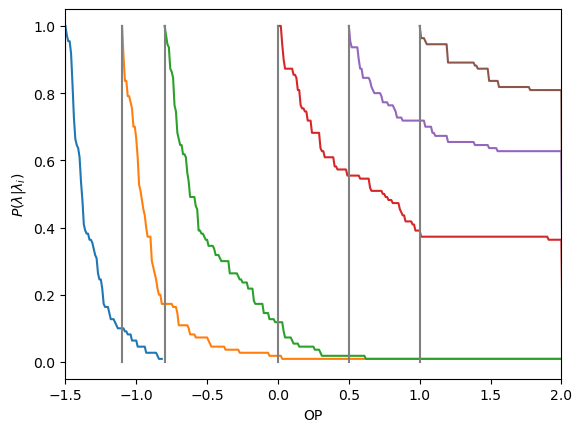

In [31]:
""" 3) Plot Crossing Probability Histogram for Each Interface Ensemble """

bin_width = 0.01 
max_bins = int((interfaces[-1]-interfaces[0])/bin_width)                        # number of lambdas between the first and last interface
counts = np.zeros((ninterfaces,max_bins))                                       # matrix to store crossing counts (for each lambda between the first and last interface)
                                                                                # size: interfaces x max_bins 

for i in range(ninterfaces):
    ndiscard = 10                                                               # this corresponds to the number of paths between each decorrelated sample/path
    for move in range(start,n_moves,ndiscard):
        val = np.max(allpaths[i][move][:,6])                                    # gets the max op of this path, tells you how far this path has travelled
        nbin = int((val-interfaces[i])/bin_width)                               # tells us how many lambdas has this path crosses

        for j in range(min(nbin+1,max_bins)):
            counts[i][j] += 1                                                   # adds 1 for each lambda that this path crosses

# Get crossing probability histogram 

lambdas = [[] for i in range(ninterfaces)]
crossingprob = [[] for i in range(ninterfaces)]

for i in range(ninterfaces):
    for j in range(max_bins):
        if counts[i][j] > 0:
            lambdas[i].append(interfaces[i]+j*bin_width)                        # this tracks the lambda corresponding to the crossing probability at that lambda
            crossingprob[i].append(counts[i][j]/counts[i][0])                   # P(lambda|lambda_i), counts[i][0] is the total number of paths of that ensemble because 
                                                                                # all paths from this ensemble would have crossed that first interface
    
# Plot the histogram

for i in range(ninterfaces):
    plt.plot(lambdas[i],crossingprob[i], label='Interface {}'.format(i))
    plt.plot(np.linspace(interfaces[i],interfaces[i],10),np.linspace(0,1,10), color='grey')
    plt.xlabel('OP')
    plt.ylabel('$P(\u03BB|\u03BB_{i})$')
# plt.legend()
plt.xlim(interfaces[0],interfaces[-1])
plt.show() 


## Continue RETIS simulation

- After the sampling check, perhaps, you have realized that you have not performed enough sampling. As such, you can continue to do so by specifying how many more moves you would like to run in **continue_moves**

In [32]:
continue_moves = 1000                                               # how many more moves would you like to simulate?

for move in range(n_moves, n_moves+continue_moves):
    
    # Swap or Shoot? 
    ss = np.random.ranf()
    
    # Perform swap move
    if ss < 0.5: 

        # Decides on which ensemble pair switching we're doing
        ens_switch = np.random.ranf() 
        
        if ens_switch < 0.5: 
            print('Move = {} ; Performing Swap Move: 1-2, 3-4, 5-6...etc'.format(move))
            
            # Accounting for the 1st interface, but first we need to check that it satisfies the ensemble criteria
            if np.where(allpaths[0][-1][:,6]>interfaces[0])[0].shape[0] == 0: 
                reject_move = True
                # print('Appending Rejected!')
            else:
                allpaths[0].append(allpaths[0][-1])                 # append the previous 0th ensemble path to its own ensemble again 
                                                                    # because there is no pair for this interface to swap with
            
            # For even number of interfaces:
            if (len(interfaces)-1)%2 == 0:                      
                
                # Accounting for the last interface 
                if np.where(allpaths[-1][-1][:,6]>interfaces[-2])[0].shape[0] == 0: 
                    reject_move = True
                    # print('Appending Rejected!')
                else:
                    allpaths[-1].append(allpaths[-1][-1])            # append the previous path of the last ensemble to its own ensemble again 
                                                                     # because there is no pair for this interface to swap with
                
                # Accounting for the rest of the interfaces
                for i in np.arange(1,len(interfaces)-3,2):
                    # print('i = ', i)
                    path_1 = allpaths[i][move-1]                     # looks at the most current path of the TPE of interface i
                    path_2 = allpaths[i+1][move-1]                   # looks at the most current path of the TPE of interface i+1
                    
                    # Check if path 1 crosses path 2's interface
                    n_cross_config = np.where(path_1[:,6]>interfaces[i+1])[0].shape[0]

                    if n_cross_config != 0:                         # if the swap is successful, do the swap
                        # print('Successful Swap!')
                        allpaths[i].append(path_2)
                        allpaths[i+1].append(path_1)
                        
                    else:                                           # if the swap is unsuccessful, just append the same path to their own ensemble
                        # print('Unsuccessful Swap!')
                        allpaths[i].append(path_1)
                        allpaths[i+1].append(path_2)
                    
            # For odd number of interfaces:
            else:                              
                for i in np.arange(1,len(interfaces)-1,2):
                    # print('i = ', i)
                    path_1 = allpaths[i][move-1]                    # looks at the most current path of the TPE of interface i
                    path_2 = allpaths[i+1][move-1]                  # looks at the most current path of the TPE of interface i+1
                    
                    # check if path 1 crosses path 2's interface
                    n_cross_config = np.where(path_1[:,6]>interfaces[i+1])[0].shape[0]

                    if n_cross_config != 0:                         # if the swap is successful, do the swap
                        # print('Successful Swap!')
                        allpaths[i].append(path_2)
                        allpaths[i+1].append(path_1)
                    
                    else:                                           # if the swap is unsuccessful, just append the same path to their own ensemble
                        # print('Unsuccessful Swap!')
                        allpaths[i].append(path_1)
                        allpaths[i+1].append(path_2)
       
        else:
            print('Move = {} ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc'.format(move))

            # For even number of interfaces: 
            if (len(interfaces)-1)%2 == 0:
                for i in range(0,len(interfaces)-1,2):
                    # print('i = ' ,i)
                    path_0 = allpaths[i][move-1]                    # looks at the most current path of the TPE of interface i
                    path_1 = allpaths[i+1][move-1]                  # looks at the most current path of the TPE of interface i+1
                    
                    # Check if path 1 crosses path 2 interface
                    n_cross_config = np.where(path_0[:,6]>interfaces[i+1])[0].shape[0]

                    if n_cross_config != 0:                         # if the swap is successful, do the swap
                        # print('Successful Swap!')
                        allpaths[i].append(path_1)
                        allpaths[i+1].append(path_0)
                    
                    else:                                           # if the swap is unsuccessful, just append the same path to their own ensemble
                        # print('Unsuccessful Swap!')
                        allpaths[i].append(path_0)
                        allpaths[i+1].append(path_1)
                    
            # For odd number of interfaces:
            else: 
                
                # Accounting for the last interface:
                if np.where(allpaths[-1][-1][:,6]>interfaces[-2])[0].shape[0] == 0: 
                    reject_move = True
                    # print('Appending Rejected!')
                else: 
                    allpaths[-1].append(allpaths[-1][-1])           # append the previous path of the last ensemble to its own ensemble again 
                                                                    # because there is no pair for this interface to swap with
                
                # Accounting for the rest of the interfaces:
                for i in range(0,len(interfaces)-2,2):
                    # print('i = ' ,i)
                    path_0 = allpaths[i][move-1]                    # looks at the most current path of the TPE of interface i
                    path_1 = allpaths[i+1][move-1]                  # looks at the most current path of the TPE of interface i+1
                    
                    # Check if path 1 crosses path 2 interface
                    n_cross_config = np.where(path_0[:,6]>interfaces[i+1])[0].shape[0]

                    if n_cross_config != 0:                         # if the swap is successful, do the swap
                        # print('Successful Swap!')
                        allpaths[i].append(path_1)
                        allpaths[i+1].append(path_0)

                    else:                                           # if the swap is unsuccessful, just append the same path to their own ensemble
                        # print('Unsuccessful Swap!')
                        allpaths[i].append(path_0)
                        allpaths[i+1].append(path_1)
                    
    # Perform shooting move
    else: 
        print('Move = {} ; Performing Shoot Move'.format(move))

        for i in np.arange(len(interfaces)-1):                      # i signifies the interface that I'm looking at
            # print('i = ', i)
            path = allpaths[i][move-1]                              # looks at the most current path of the TPE of interface i
            reject_move = False
            lmax = round((len(path) + 1)/np.random.uniform())       # l max = maximum path length for flexible shooting 
            
            # Pick random shooting point 
            if i == 0:
                minus_frame = find_config_minus(path, basinA)            # find the index corresponding to interface i-1    
                plus_frame = find_config_plus(path, interfaces[i+1])     # find the index corresponding to interface i+1 
                index = np.random.randint(minus_frame,plus_frame)

            # Pick random shooting point between i-1 and i+1
            else:               
                minus_frame = find_config_minus(path, interfaces[i-1])    # find the index corresponding to interface i-1    
                plus_frame = find_config_plus(path, interfaces[i+1])      # find the index corresponding to interface i+1  
                index = np.random.randint(minus_frame,plus_frame)

            # Perturb the momenta
            shoot_point = copy.deepcopy(path[index])                # gives me 1 phase space point/config along the path
            shoot_point[2] += np.random.normal(0,sigma)             # px
            shoot_point[3] += np.random.normal(0,sigma)             # py
            trial_path = np.asarray([shoot_point])                  # new trial path after perturbing the momenta

            if exp(-beta*(ld.kinetic_energy(shoot_point) - ld.kinetic_energy(path[index]))) < np.random.uniform():
                # the if is testing to see if we want to use this new trial path (after momenta is perturbed) 
                # before even shooting it
                reject_move = True
                # print('Shooting Move Rejected! Momenta Perturbation Failed!') 

            # Integrate backwards path if we have not rejected the move...
            if reject_move == False:
                path_length = 1
                trial_path[:,2] *=-1                                    # change px to the negative direction by * -1
                trial_path[:,3] *=-1                                    # change py to the negative direction by * -1
                trajstep = copy.deepcopy(trial_path[-1])                # take the last config of trial path
                op = ld.calc_op(op_type,trajstep[0],trajstep[1])        # calc op value for config

                while op >= basinA:
                    trajstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)   # ld.vv_step(x,y,px,py,fx,fy,dt,beta,gamma)
                    op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                    trajstep = np.append(trajstep,[op],axis=0)
                    trial_path = np.append(trial_path,[trajstep],axis=0)
                    path_length +=1

                    # Reject if the maximum path length is exceeded
                    if path_length > lmax:
                        reject_move = True
                        # print('Shooting Move Rejected! Pathlength limit!')
                        break

                    # Reject if the backward path segment goes to B
                    if op >= basinB:
                        reject_move = True
                        # print('Shooting Move Rejected! Backward segment reaches B!')
                        break

            # Forward shooting             
            if reject_move == False: 
                trial_path = np.flip(trial_path,axis=0)                  # flip it from the back to front of this trial path (because it was shooting backwards), 
                                                                         # so we flip so that the last config we extract from here will be where we'll use to shoot forward
                trial_path[:,2] *=-1
                trial_path[:,3] *=-1
                trajstep = copy.deepcopy(trial_path[-1])
                op = ld.calc_op(op_type,trajstep[0],trajstep[1])
     
                while op > basinA and op < basinB:                       # this is so that it restricts forward shooting to either end in A or B

                    nextstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)
                    trajstep = nextstep
                    op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                    trajstep = np.append(trajstep,[op],axis=0)
                    trial_path = np.append(trial_path,[trajstep],axis=0)
                    path_length +=1
                    
                    if path_length > lmax:
                        reject_move = True
                        # print('Shooting Move Rejected! Pathlength Limit!')
                        break

            # Final chance to reject a path (because no crossing of interface i)
            if np.where(trial_path[:,6]>interfaces[i])[0].shape[0] == 0: # np.where(condition)[0] tells you which array or which path satisfies this condition 
                                                                         # and the .shape[0] how many configs satisfy this, if 0, then we never cross the interface
                reject_move = True
                # print('Shooting Move Rejected! Did not cross its own interface!')
            
            # If we DON'T reject, then path becomes trial path
            if reject_move == False:
                # print('Shooting Move Accepted!')
                path = trial_path
            
            # Append current accepted path to its corresponding path ensemble
            allpaths[i].append(path)                                    # all paths contains all paths per each interface - i is to signify which interface ensemble 
                                                                        # we're looking at. So allpaths[0] will contain all paths that cross interface lambda 0

Move = 1500 ; Performing Shoot Move
Move = 1501 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 1502 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 1503 ; Performing Shoot Move
Move = 1504 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 1505 ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc
Move = 1506 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 1507 ; Performing Shoot Move
Move = 1508 ; Performing Shoot Move
Move = 1509 ; Performing Shoot Move
Move = 1510 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 1511 ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc
Move = 1512 ; Performing Swap Move: 0-1, 2-3, 4-5, ...etc
Move = 1513 ; Performing Shoot Move
Move = 1514 ; Performing Shoot Move
Move = 1515 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 1516 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 1517 ; Performing Swap Move: 1-2, 3-4, 5-6...etc
Move = 1518 ; Performing Shoot Move
Move = 1519 ; Performing Shoot Move
Move = 1520 ; Performing Shoot Move
Move = 1521 ; Perf

## Visualize Crossing Histogram Again

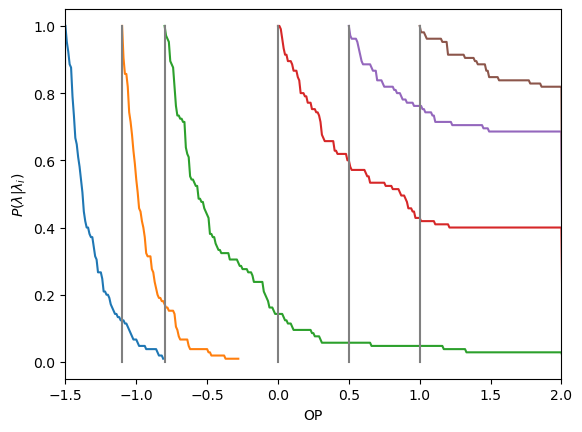

In [33]:
""" 3) Plot Crossing Probability Histogram for Each Interface Ensemble """

bin_width = 0.01 
max_bins = int((interfaces[-1]-interfaces[0])/bin_width)                        # number of lambdas between the first and last interface
counts = np.zeros((ninterfaces,max_bins))                                       # matrix to store crossing counts (for each lambda between the first and last interface)
                                                                                # size: interfaces x max_bins 

for i in range(ninterfaces):
    ndiscard = 20                                                               # this corresponds to the number of paths between each decorrelated sample/path
    for move in range(start,n_moves+continue_moves,ndiscard):
        val = np.max(allpaths[i][move][:,6])                                    # gets the max op of this path, tells you how far this path has travelled
        nbin = int((val-interfaces[i])/bin_width)                               # tells us how many lambdas has this path crosses

        for j in range(min(nbin+1,max_bins)):
            counts[i][j] += 1                                                   # adds 1 for each lambda that this path crosses

# Get crossing probability histogram 

lambdas = [[] for i in range(ninterfaces)]
crossingprob = [[] for i in range(ninterfaces)]

for i in range(ninterfaces):
    for j in range(max_bins):
        if counts[i][j] > 0:
            lambdas[i].append(interfaces[i]+j*bin_width)                           # this tracks the lambda corresponding to the crossing probability at that lambda
            crossingprob[i].append(counts[i][j]/counts[i][0])                      # P(lambda|lambda_i), counts[i][0] is the total number of paths of that ensemble because all paths from this ensemble would have crossed that first interface

   
# Plot the crossing histogram 

for i in range(ninterfaces):
    plt.plot(lambdas[i],crossingprob[i], label='Interface {}'.format(i))
    plt.plot(np.linspace(interfaces[i],interfaces[i],10),np.linspace(0,1,10), color='grey')
    plt.xlabel('OP')
    plt.ylabel('$P(\u03BB|\u03BB_{i})$')
# plt.legend()
plt.xlim(interfaces[0],interfaces[-1])
plt.show() 


## Plot the paths collected at each interface

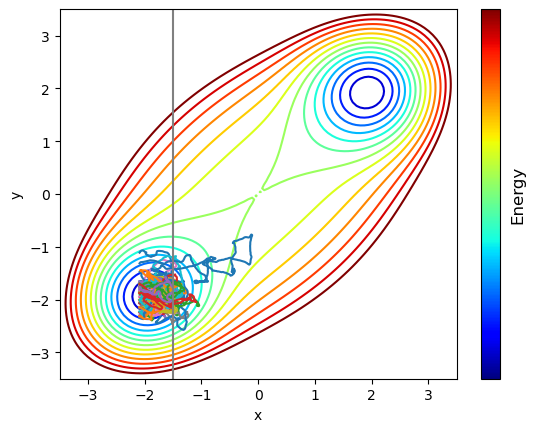

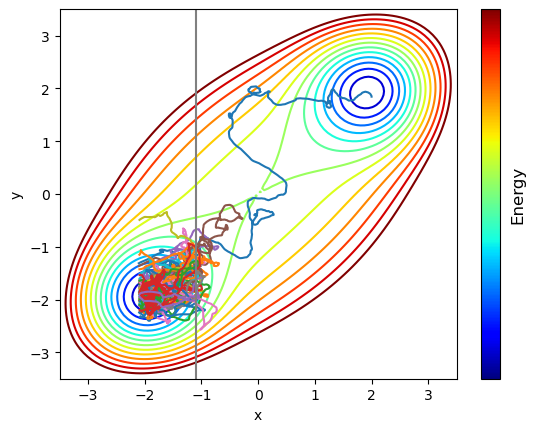

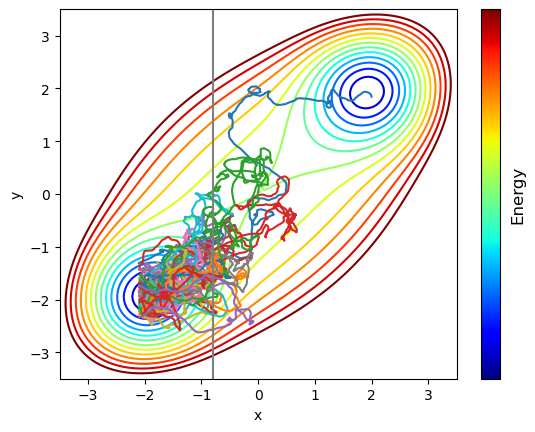

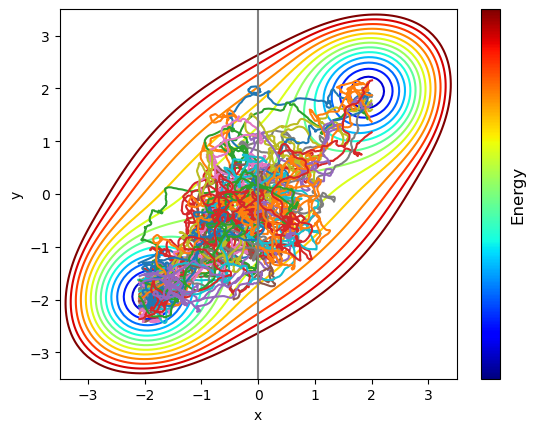

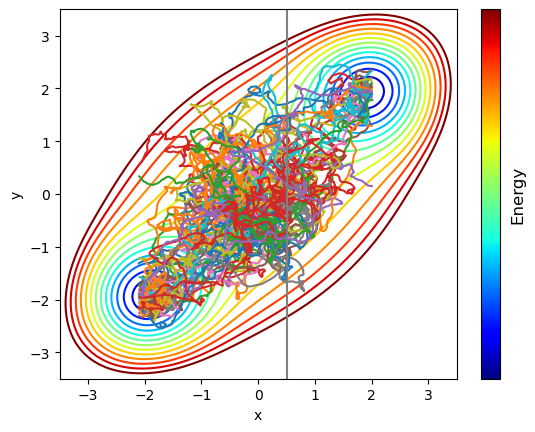

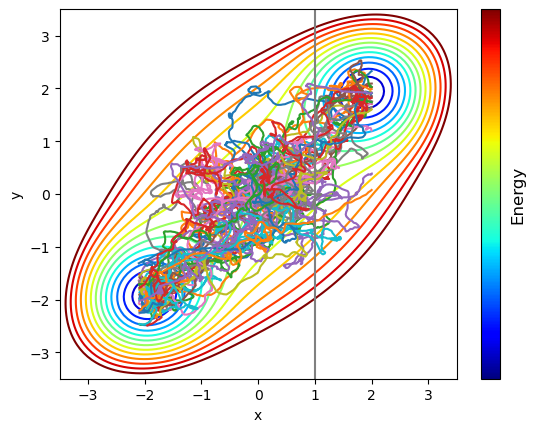

In [34]:
# Plot sampled paths from each interface
skip = 100

for i in range(len(interfaces) - 1):
    plt.figure()

    if pes_type == 4:
        plt.contour(x_vec,y_vec,energy,np.linspace(-100,100,30), cmap = 'jet')
    else:   
        plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')
        
    for j in range(1,len(allpaths[i]),skip):
        plt.plot(allpaths[i][j][:,0],allpaths[i][j][:,1]) # allpaths[i] tells you the interface ensemble you're in, [j] tells you a specific path in that ensemble, [:,0/1] takes all the x/y values of the paths in i
    plt.plot(np.linspace(interfaces[i],interfaces[i],10),np.linspace(min(y_vec),max(y_vec),10), color='grey')
    cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
    cbar.set_ticks([])
    cbar.set_label(label = 'Energy', size=12)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show

## Calculate the rate 

In [35]:
# Calculate flux

flux = n_cross_flux/(basinlen*dt)
print("Flux through first interface: {}\n".format(flux))
print("Number of first crossings: {}\n".format(n_cross_flux))

# Calculate Rate
cross_probs = 1

for i in range(ninterfaces):
    for j in lambdas[i]:
        if j == interfaces[i+1]:
            index = np.where(np.array(lambdas[i])==j)[0][0]
            # print(index, crossingprob[i][index])
            cross_probs *= crossingprob[i][index]

rate = flux*cross_probs                                    # flux from the first crossing * product of crossing probability of all interface
print("Rate: {:e}".format(rate))


Flux through first interface: 0.052

Number of first crossings: 26

Rate: 5.903420e-05


## Rate Answer Key

In [36]:
"""" Rate Answer Key """

# For PES-1: Rate = 
# For PES-2: Rate = 
# For PES-3: Rate = 


'" Rate Answer Key '